# **Local Invariant Features and SIFT descriptors**
## Image Processing and Computer Vision - Lab Session No. 2


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

# Solutions

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!ls /content/drive/MyDrive/LabSessionsIPCV
!cp -r /content/drive/MyDrive/LabSessionsIPCV/lab_session_2_images.zip ./
!unzip lab_session_2_images.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lab_session_1_images.zip  lab_session_1_solutions.ipynb  lab_session_2.ipynb
lab_session_1.ipynb	  lab_session_2_images.zip	 lab_session_2_solutions.ipynb
Archive:  lab_session_2_images.zip
replace bishop.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Exercise 1: Image Search


Found query object in scene1.jpg: True


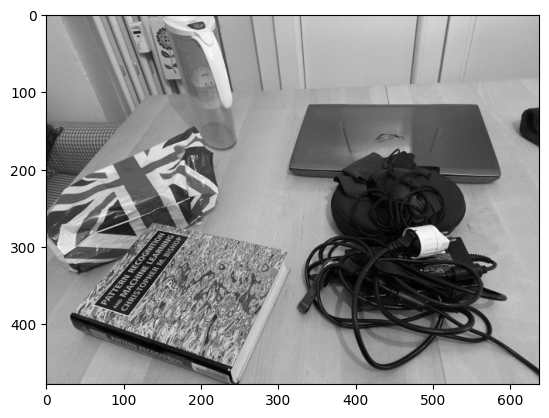


Found query object in scene2.jpg: True


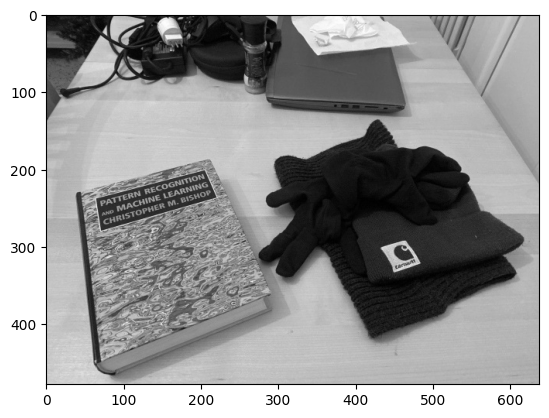


Found query object in scene3.jpg: True


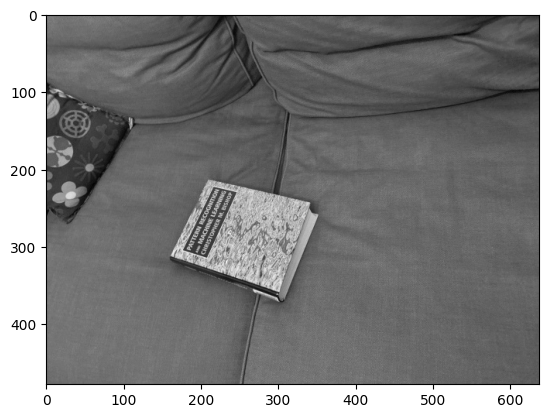


Found query object in scene4.jpg: False

Found query object in scene5.jpg: False


In [ ]:
def detect_object(img_model, img_scene, min_match_count):
    sift = cv2.SIFT_create()
    kp_model = sift.detect(img_model)
    kp_scene = sift.detect(img_scene)
    kp_model, des_model = sift.compute(img_model, kp_model)
    kp_scene, des_scene = sift.compute(img_scene, kp_scene)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_model, des_scene, k=2)

    # Store the good matches according to Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    if len(good) > min_match_count:
        return len(good)
    else:
        return -1

img_model = cv2.imread("bishop.jpg", cv2.IMREAD_GRAYSCALE)
imgs_scene = ["scene1.jpg", "scene2.jpg", "scene3.jpg", "scene4.jpg", "scene5.jpg"]

# Iterating over all images and looking for the query object
for path in imgs_scene:
    img_scene = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    found = detect_object(img_model, img_scene, 50)
    print(f"\nFound query object in {path}: {found > 0}")
    if found > 0:
        plt.imshow(img_scene, "gray", vmin=0, vmax=255)
        plt.show()

## Exercise 2: Mosaicing (a.k.a. Panorama Stitching)

In [ ]:
# Loading images
img1 = cv2.imread("panorama_left_rgb.jpg")[:, :, ::-1]
img2 = cv2.imread("panorama_right_rgb.jpg")[:, :, ::-1]
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.show()

# Getting correspondences
sift = cv2.SIFT_create()
kp1 = sift.detect(img1)
kp2 = sift.detect(img2)
kp1, des1 = sift.compute(img1, kp1)
kp2, des2 = sift.compute(img2, kp2)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# Finding a homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
matches_mask = mask.ravel().tolist()

# Drawing matches
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=None,
    matchesMask=matches_mask,
    flags=2
)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.figure(figsize=(16, 8))
plt.imshow(img3)
plt.show()

# Warping right image with the homography. Result images have a bigger shape to contain both images.
# Use the cv2.warpPerspective(image_to_warp, homography_matrix, output_shape) function
# to warp the second image to match the first one.
result = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], img2.shape[0]))

# Restoring left image values into the result image
result[0:img1.shape[0], 0:img1.shape[1]] = img1

# Displaying the result
plt.figure(figsize=(16, 8))
plt.imshow(result)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Exercise 3: Augmented Reality

Scene Image


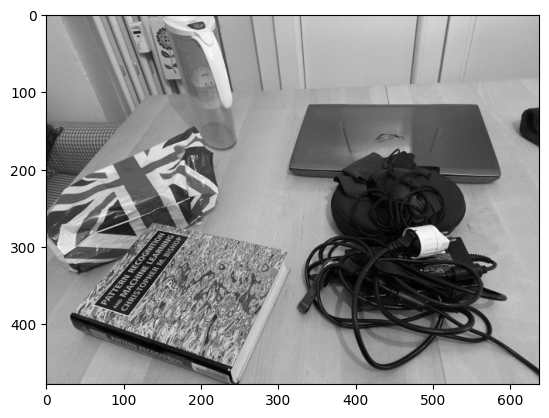


Model Image


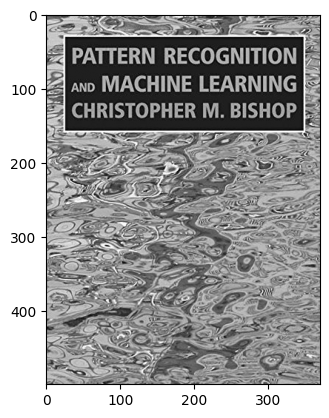


Image to Project


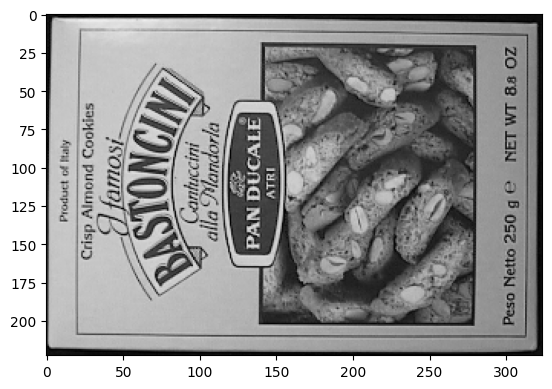


Mask


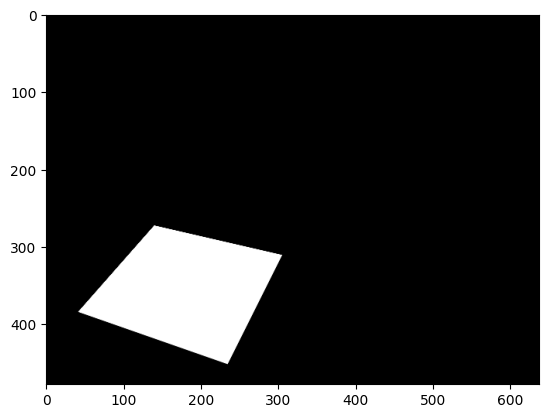


Result Image


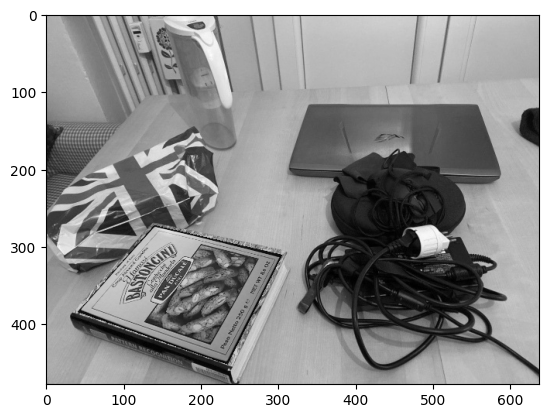

In [ ]:
# Loading images
img_scene = cv2.imread("scene1.jpg", cv2.IMREAD_GRAYSCALE)
img_model = cv2.imread("bishop.jpg", cv2.IMREAD_GRAYSCALE)
img_ar = cv2.imread("box.png", cv2.IMREAD_GRAYSCALE)

print("Scene Image")
plt.imshow(img_scene, cmap="gray", vmin=0, vmax=255)
plt.show()
print("\nModel Image")
plt.imshow(img_model, cmap="gray", vmin=0, vmax=255)
plt.show()
print("\nImage to Project")
plt.imshow(img_ar, cmap="gray", vmin=0, vmax=255)
plt.show()

# For a better visualization in the scene image
# https://numpy.org/doc/stable/reference/generated/numpy.rot90.html
img_ar = np.rot90(img_ar, 3)

# Implementing the object detection pipeline
sift = cv2.SIFT_create()
kp_model = sift.detect(img_model)
kp_scene = sift.detect(img_scene)
kp_model, des_model = sift.compute(img_model, kp_model)
kp_scene, des_scene = sift.compute(img_scene, kp_scene)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_model, des_scene, k=2)
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# Checking if we found the object
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Getting the coordinates of the corners of the model object in the scene image
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h, w = img_model.shape
    pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]])
    dst = cv2.perspectiveTransform(np.array([pts]), M)

    h_t, w_t = img_scene.shape
    h, w = img_ar.shape

    # Getting the homography to project img_ar on the surface of the query object
    pts_ar = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1, 1, 2)
    M = cv2.getPerspectiveTransform(pts_ar, dst)

    # Warping img_ar
    warped = cv2.warpPerspective(img_ar, M, (w_t, h_t))

    # Warping a white mask
    white = np.ones([h, w], dtype=np.uint8) * 255
    warp_mask = cv2.warpPerspective(white, M, (w_t, h_t))
    print("\nMask")
    plt.imshow(warp_mask, "gray", vmin=0, vmax=255)
    plt.show()

    # Restoring previous values of the scene image where the mask is black
    warp_mask = np.equal(warp_mask, 0)
    warped[warp_mask] = img_scene[warp_mask]

    # Displaying the result
    print("\nResult Image")
    plt.imshow(warped, cmap="gray", vmin=0, vmax=255)
    plt.show()

else:
    print(f"\nNot enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")